### CS 421 PROJECT

In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import random
import joblib

In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [21]:
# Load the dataset
data = np.load("first_batch_multi_labels.npz")
X = data["X"]
y = data["yy"]

# Create DataFrames
df_X = pd.DataFrame(X, columns=["user", "item", "rating"])
df_y = pd.DataFrame(y, columns=["user", "label"])

def engineer_features(df_X, top_features=None, df_y=None):
    # Basic user features
    df_user_features = df_X.groupby('user').agg(
        mean_rating=('rating', 'mean'),
        median_rating=('rating', 'median'),
        std_rating=('rating', 'std'),
        count_dislike=('rating', lambda x: (x == -10).sum()),
        count_neutral=('rating', lambda x: (x == 0).sum()),
        count_like=('rating', lambda x: (x == 10).sum()),
        count_watched=('rating', lambda x: (x == 1).sum()),
        total_interactions=('rating', 'count')
    )

    # Ratio features
    # df_user_features['like_ratio'] = df_user_features['count_like'] / df_user_features['total_interactions']
    # df_user_features['dislike_ratio'] = df_user_features['count_dislike'] / df_user_features['total_interactions']
    # df_user_features['neutral_ratio'] = df_user_features['count_neutral'] / df_user_features['total_interactions']
    # df_user_features['watched_ratio'] = df_user_features['count_watched'] / df_user_features['total_interactions']

    df_user_features['like_ratio'] = np.log(df_user_features['count_like']+1) - np.log(df_user_features['total_interactions'])
    df_user_features['dislike_ratio'] = np.log(df_user_features['count_dislike']+1) - np.log(df_user_features['total_interactions'])
    df_user_features['neutral_ratio'] = np.log(df_user_features['count_neutral']+1) - np.log(df_user_features['total_interactions'])
    df_user_features['watched_ratio'] = np.log(df_user_features['count_watched']+1) - np.log(df_user_features['total_interactions'])
    
    # df_user_features['unrated_to_rated_ratio'] = (df_user_features['count_neutral'] + df_user_features['count_watched']) / (df_user_features['count_like']+ df_user_features['count_dislike']+1)
    
    # df_user_features['unrated_to_rated_ratio'] = np.log(df_user_features['count_neutral'] + df_user_features['count_watched']+1) - np.log(df_user_features['count_like']+ df_user_features['count_dislike']+1)
    
    # Interaction patterns
    df_user_features['like_to_dislike_ratio'] = np.log(df_user_features['count_like']+1) - np.log(df_user_features['count_dislike'] + 1)                                                                                                                                   
    # df_user_features['like_to_dislike_ratio'] = df_user_features['count_like'] / (df_user_features['count_dislike'] + 1)
    df_user_features['rating_variance'] = df_X.groupby('user')['rating'].var()
    
    # Distribution features
    df_user_features['rating_skew'] = df_X.groupby('user')['rating'].apply(lambda x: skew(x))
    df_user_features['rating_kurtosis'] = df_X.groupby('user')['rating'].apply(lambda x: kurtosis(x))
    
    # User behavior patterns
    df_user_features['rating_range'] = df_X.groupby('user')['rating'].apply(lambda x: x.max() - x.min())
    df_user_features['unique_items_ratio'] = np.log(df_X.groupby('user')['item'].nunique()) - np.log(df_user_features['total_interactions'])
    
    # Item popularity metrics
    item_popularity = df_X.groupby('item')['rating'].agg(['mean', 'count'])
    item_popularity['popularity_score'] = item_popularity['mean'] * np.log1p(item_popularity['count'])
    
    # Merge item popularity with user interactions
    df_X_with_popularity = pd.merge(df_X, item_popularity['popularity_score'], left_on='item', right_index=True)
    
    # User-item interaction features
    df_user_features['mean_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].mean()
    df_user_features['std_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].std()

    # If labels are provided, merge with df_y
    if df_y is not None:
        df_merged = pd.merge(df_user_features.reset_index(), df_y, on='user')

        # Feature selection using mutual information
        X = df_merged.drop(columns=['user', 'label'])
        y = df_merged['label']
        mi_scores = mutual_info_classif(X, y)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
        
        # Select top 15 features
        top_features = mi_scores.nlargest(10).index.tolist()

        # Return the merged dataframe with selected features, label, and top features
        return df_merged[['user'] + top_features + ['label']], top_features

    # If no labels (unseen data), just select the top features
    else:
        # Ensure top_features is provided
        if top_features is None:
            raise ValueError("top_features must be provided for unseen data")
        
        # Return the dataframe with only the selected top features
        df_merged = df_user_features.reset_index()
        return df_merged[['user'] + top_features]

# Use the function
df_merged, top_features = engineer_features(df_X, df_y=df_y)

# Features and Labels
X_features = df_merged.drop(columns=['user', 'label', 'like_ratio', 'dislike_ratio', 'std_rating'])
y_labels = df_merged['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=RANDOM_SEED, stratify=y_labels)

# Handling imbalance in the training set using SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Model Training with Random Forest in One-vs-Rest scheme
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, class_weight='balanced')
ovr_model = OneVsRestClassifier(rf_model)

# Use a pipeline for scaling and modeling
pipeline = make_pipeline(StandardScaler(), ovr_model)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'onevsrestclassifier__estimator__n_estimators': [100, 200, 300],
    'onevsrestclassifier__estimator__max_depth': [10, 20, 30],
    'onevsrestclassifier__estimator__min_samples_split': [2, 5, 10],
    'onevsrestclassifier__estimator__min_samples_leaf': [1, 2, 4],
    'onevsrestclassifier__estimator__max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc_ovr', n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Use the best model from grid search
best_model = grid_search.best_estimator_

# Final evaluation on the test set
y_test_pred_prob = best_model.predict_proba(X_test)
test_auc_scores = roc_auc_score(y_test, y_test_pred_prob, average=None, multi_class='ovr')
print(f"Test AUC Scores: Normal (Class 0): {test_auc_scores[0]:.4f}, Anomaly 1 (Class 1): {test_auc_scores[1]:.4f}, Anomaly 2 (Class 2): {test_auc_scores[2]:.4f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
243 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
71 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^

Test AUC Scores: Normal (Class 0): 0.9885, Anomaly 1 (Class 1): 0.9890, Anomaly 2 (Class 2): 0.9995


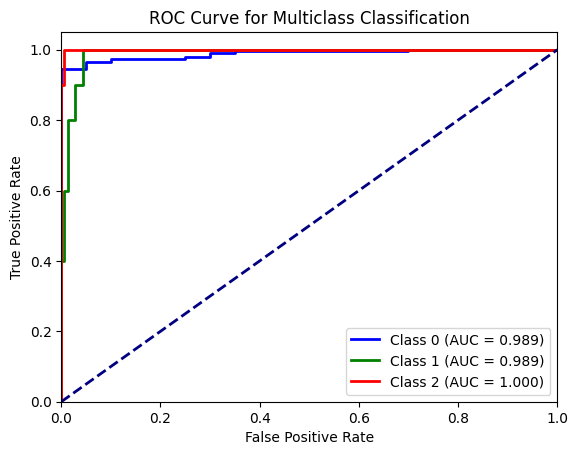

In [22]:
# Binarize the output labels for multiclass ROC curve calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

[[193   6   1]
 [  1   9   0]
 [  0   0  10]]


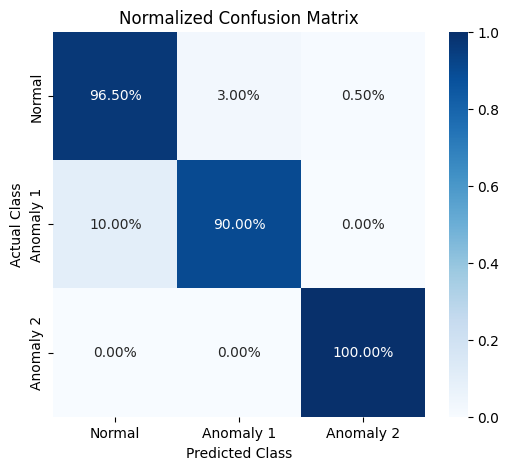

In [23]:
# Make predictions (convert probabilities to class labels)
y_pred = best_model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Normalize the confusion matrix by the number of samples in each class
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display the normalized confusion matrix using Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'], 
            yticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'])

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [16]:
data_with_no_labels = np.load("second_batch_multi.npz")

df_X = pd.DataFrame(data_with_no_labels["X"], columns=["user", "item", "rating"])

df_unseen_features = engineer_features(df_X, top_features=top_features)

y_pred_prob_unseen = best_model.predict_proba(df_unseen_features.drop(columns=['user']))
y_pred_class_unseen = best_model.predict(df_unseen_features.drop(columns=['user']))

# Create a DataFrame to hold user IDs and their corresponding anomaly scores
df_anomaly_scores = pd.DataFrame({
    'user': df_unseen_features['user'],  # User IDs from unseen data
    'z0': y_pred_prob_unseen[:, 0],  # Probability for Normal class
    'z1': y_pred_prob_unseen[:, 1],  # Probability for Anomaly 1
    'z2': y_pred_prob_unseen[:, 2],   # Probability for Anomaly 2
    'predicted_class': y_pred_class_unseen   # Predicted class (0, 1, or 2)
})

df_anomaly_scores

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- dislike_ratio
- like_ratio
- std_rating


In [ ]:
df_anomaly_scores.to_csv("second_batch_anomaly_scores_hyperparameter.csv", index=False)

In [24]:
# Get RF 1, see feature importances as its doing better than Alex's
def get_feature_importances(pipeline, clf_no: int):
    clf1 = pipeline[1].estimators_[clf_no]
    importances = clf1.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf1.estimators_], axis=0)
    forest_importances = pd.Series(importances,index = X_features.columns)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax = ax)
    ax.set_title(f"Feature importances for class {clf_no}: using Mean Decrease in Impurity")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()

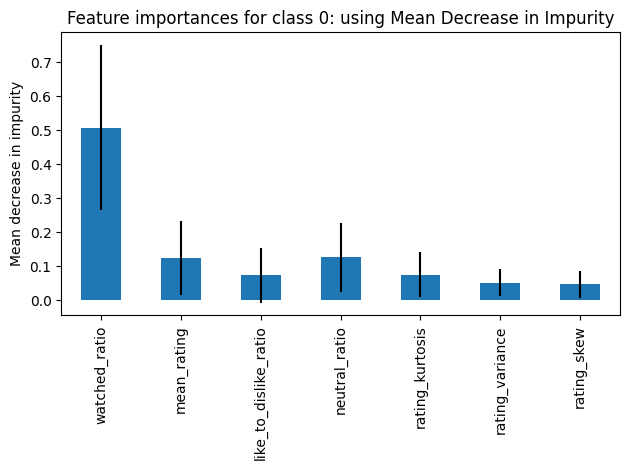

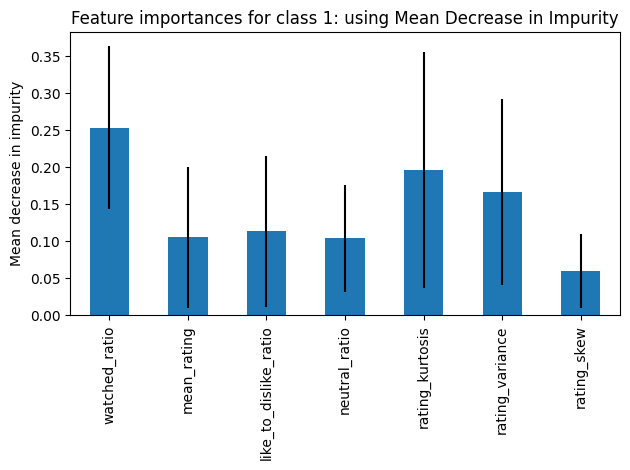

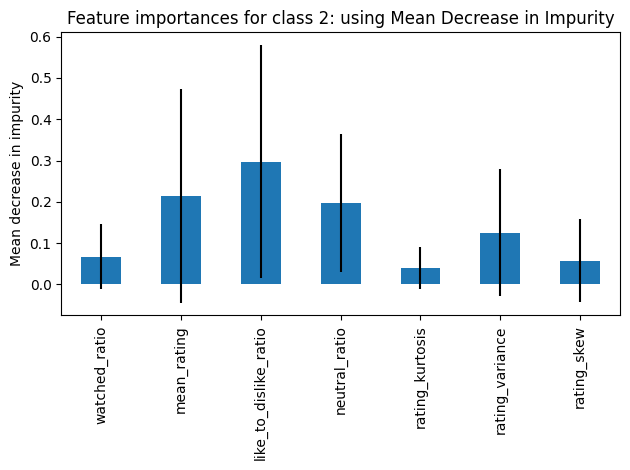

In [25]:
get_feature_importances(grid_search.best_estimator_, clf_no = 0)
get_feature_importances(grid_search.best_estimator_, clf_no = 1)
get_feature_importances(grid_search.best_estimator_, clf_no = 2)

In [26]:
def process_resampled(X_resampled, X_test):
    # from sklearn.preprocessing import PolynomialFeatures, StandardScaler
    cols = ['watched_ratio', 'mean_rating', 'unrated_to_rated_ratio', 'like_to_dislike_ratio', 'dislike_ratio', 'neutral_ratio', 'rating_variance']
    X_resampled_v2 = X_resampled[cols]
    X_test_v2 = X_test[cols]
    # poly = PolynomialFeatures(degree = 2).fit(X_resampled_v2)
    # X_resampled_poly = poly.transform(X_resampled_v2)
    # X_test_poly = poly.transform(X_test_v2)

    scalar = StandardScaler().fit(X_resampled_v2)
    X_resampled_poly_norm = scalar.transform(X_resampled_v2)
    X_test_poly_norm = scalar.transform(X_test_v2)

    
    # poly = PolynomialF
    # return X_resampled_v2, X_test_v2
    return X_resampled_poly_norm, X_test_poly_norm
X_resampled_v2, X_test_v2 = process_resampled(X_resampled, X_test)

KeyError: "['unrated_to_rated_ratio', 'dislike_ratio'] not in index"

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_resampled_v2, y_resampled)
y_pred_prob_v2 = lr.predict_proba(X_test_v2)

y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

In [ ]:
grid_search.best_params_

In [ ]:
y_pred_v2 = lr.predict(X_test_v2)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_v2)
print(conf_matrix)

# Normalize the confusion matrix by the number of samples in each class
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display the normalized confusion matrix using Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'], 
            yticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'])

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [27]:
def make_confusion_matrix(model, Xs, y_true):
    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(Xs)
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    # df = pd.DataFrame(conf_matrix_normalized)
    # df = df.style.background_gradient(axis = 1, cmap = 'Blues')
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'], 
                yticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'])
    
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()
    # display(df)

In [28]:
def plot_roc_curve(fprs, tprs, roc_aucs, title):
    import matplotlib.pyplot as plt
    plt.figure()
    colors = ['blue', 'green', 'red']
    for i, color in zip(range(3), colors):
        plt.plot(fprs[i], tprs[i], label = f'Class{i} (AUC = {roc_aucs[i]:.3f})')

    plt.plot([0,1],[0,1], linestyle = '--', alpha = 0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {title}')
    plt.legend(loc = 'lower right')
    plt.show()

Generating train-test split on random state  9127424


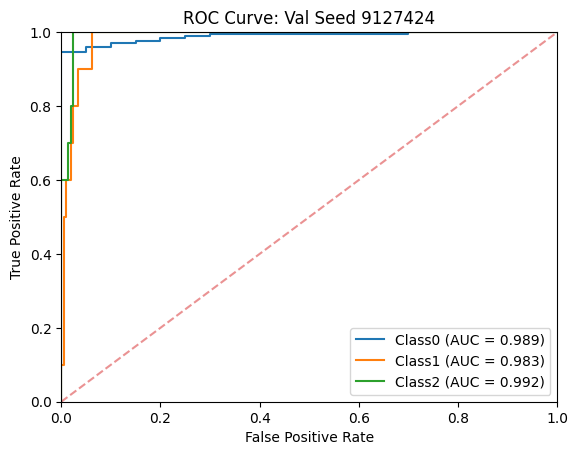

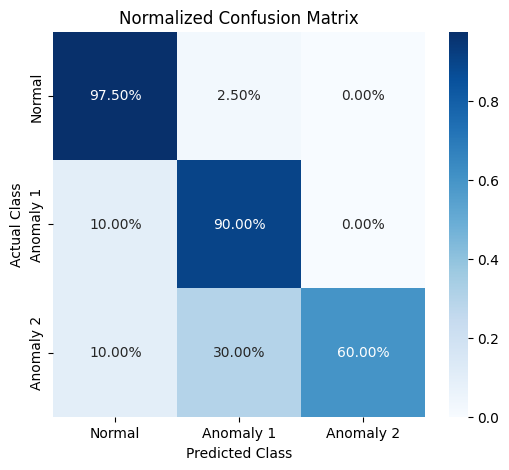

Generating train-test split on random state  2041635


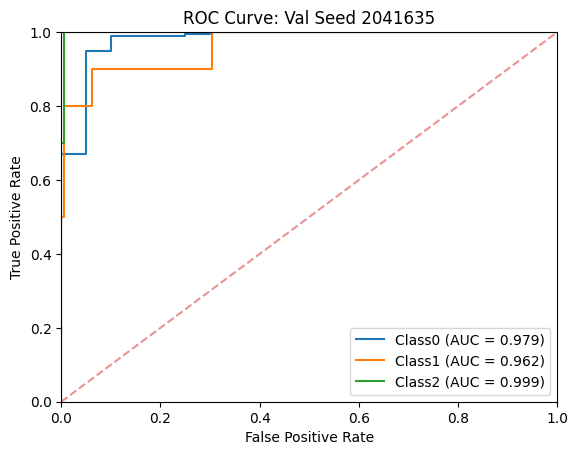

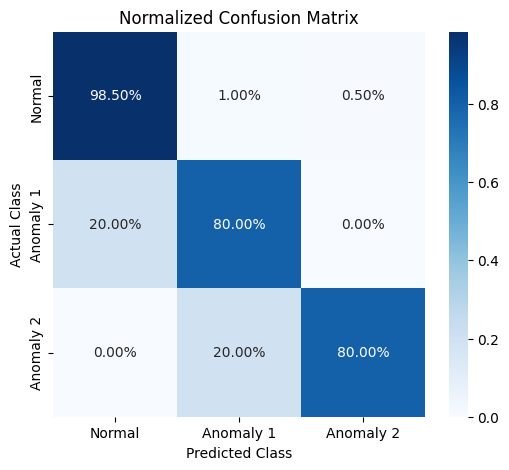

Generating train-test split on random state  7395367


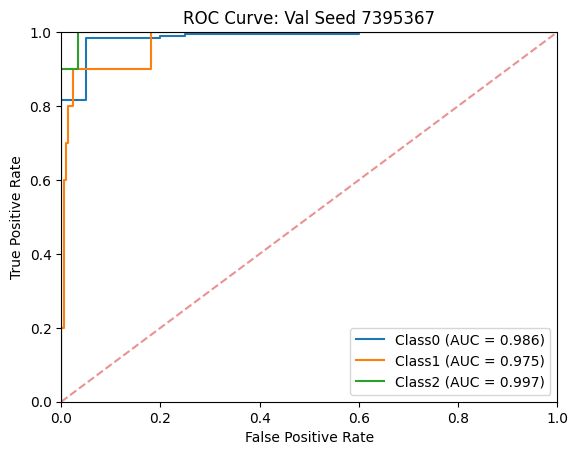

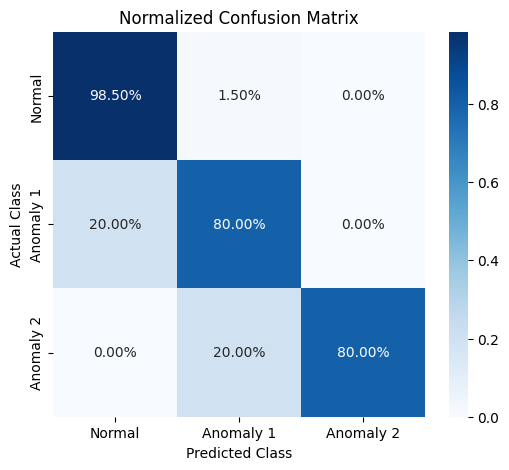

Generating train-test split on random state  9021002


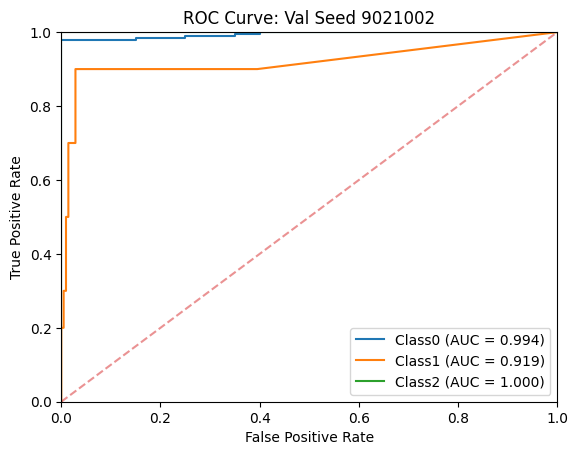

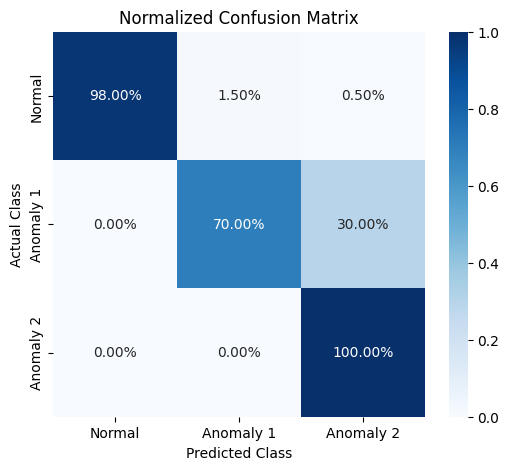

Generating train-test split on random state  1445043


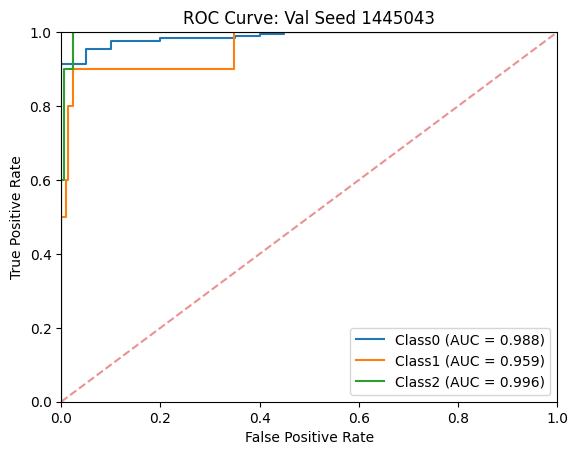

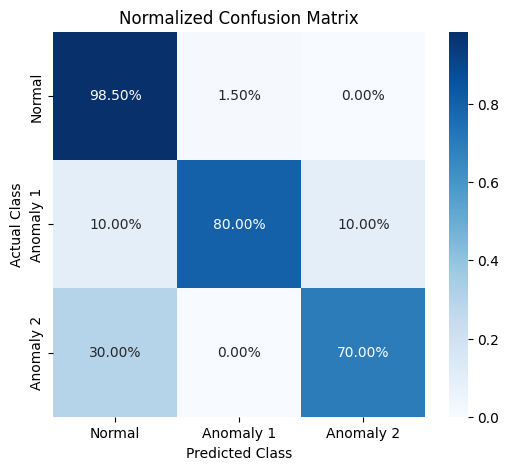

,9127424,2041635,7395367,9021002,1445043
0,0.989250,0.979250,0.986250,0.994250,0.988000
1,0.983333,0.961905,0.975238,0.919286,0.959048
2,0.991905,0.998571,0.996667,1.000000,0.996190


In [29]:
# 5 different test splits
def final_check(params: dict):
    import copy
    test_state = 5792546
    # test_state = 6943519
    val_states = [9127424, 2041635, 7395367, 9021002, 1445043]
    val_results = dict()
    test_results = dict()
    for val_seed in val_states:
        print("Generating train-test split on random state ", val_seed)
        data = np.load("first_batch_multi_labels.npz")
        X = data["X"]
        y = data["yy"]
        df_X = pd.DataFrame(X, columns=["user", "item", "rating"])
        df_y = pd.DataFrame(y, columns=["user", "label"])
        
        # Use the function
        df_merged, top_features = engineer_features(df_X, df_y=df_y)
        
        # Features and Labels
        X_features = df_merged.drop(columns=['user', 'label'])
        y_labels = df_merged['label']
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=test_state, stratify=y_labels)

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=val_seed, stratify= y_train)
            
        # SMOTE
        # Handling imbalance in the training set using SMOTE
        smote = SMOTE(random_state=RANDOM_SEED)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        
        best_rf_params = {
            key.replace('onevsrestclassifier__estimator__' , ''): value
            for key, value in params.items() if 'onevsrestclassifier__estimator__' in key
        }
        rf = RandomForestClassifier(**best_rf_params)
        ovr = OneVsRestClassifier(rf)
        pipeline = make_pipeline(StandardScaler(), ovr)
        
        pipeline = pipeline.fit(X_resampled, y_resampled)
        y_val_prob = pipeline.predict_proba(X_val)

        # Evaluate on validation set
        y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
        fprs = {}
        tprs = {}
        roc_aucs = {}
        for i in range(3):
            fprs[i], tprs[i], _ = roc_curve(y_val_binarized[:, i], y_val_prob[:,i])
            roc_aucs[i] = auc(fprs[i], tprs[i])
        plot_roc_curve(fprs, tprs, roc_aucs, f'Val Seed {val_seed}')
        make_confusion_matrix(pipeline, X_val, y_val)
        val_results[val_seed] = copy.deepcopy(roc_aucs)

        # Evaluate on test set 
        y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
        y_test_prob = pipeline.predict_proba(X_test)
        fprs = {}
        tprs = {}
        roc_aucs = {}
        for i in range(3):
            fprs[i], tprs[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:,i])
            roc_aucs[i] = auc(fprs[i], tprs[i])
        # plot_roc_curve(fprs, tprs, roc_aucs, f'Val Seed {val_seed}')
        # make_confusion_matrix(pipeline, X_test, y_test)
        test_results[val_seed] = copy.deepcopy(roc_aucs)
    
    return test_results, val_results
test_results, val_results = final_check(grid_search.best_params_)
pd.DataFrame(val_results)

In [30]:
val_df = pd.DataFrame(val_results)
print("Mean Val AUC per class")
display(val_df.mean(axis=1).to_frame())
print("Std val AUC per class")
display(val_df.std(axis=1).to_frame())

Mean Val AUC per class


,0
0,0.987400
1,0.959762
2,0.996667


Std val AUC per class


,0
0,0.005442
1,0.024691
2,0.003068


In [31]:
test_df = pd.DataFrame(test_results)
print("Mean Val AUC per class")
display(test_df.mean(axis=1).to_frame())
print("Std val AUC per class")
display(test_df.std(axis=1).to_frame())

Mean Val AUC per class


,0
0,0.947200
1,0.934429
2,0.991810


Std val AUC per class


,0
0,0.018902
1,0.028123
2,0.003357
